# Implementing Global Sensitivity Analysis for Different Cases of the Macrophage Tumor Population Model

### Define System of ODEs
Our state variables are $T$, tumor volume, $M_0$, naive macrophages, $M_1$,  M1-like macrophages, $M_2$, M2-like macrophages, and $M_m$, mixed (or $M_1/M_2$) phenotype macrophages.


Model Equations (see Overleaf document for pathways and justification):

$\frac{dT}{dt}={p_T \cdot T \cdot \left(1-T\right)(h -r_1M_1+ r_2M_2 )} - {d_T T}$
$\frac{dM_0}{dt}={p_{0}T\left(1-\frac{M_0+M_1+M_2+M_m}{f}\right)\left(1+\gamma M_1\right)} - \left({d_{0}} + {\alpha_{01}} + {\alpha_{02} \left(1+\frac{\beta T}{T+f}\right)}\right)M_0 + {\alpha_{10}M_1} + {\alpha_{20}M_2}$
$ \frac{dM_1}{dt}= -\left({d_{1}} + {\alpha_{10}}  + {\alpha_{12} \left(1+ \frac{\beta T}{T+f}\right)} + {\alpha_{1m}  \left(1+ \frac{\beta T}{T+f}\right)}\right)M_1 + {\alpha_{01}M_0} +{\alpha_{21}M_2}  + {\alpha_{m1}M_m}$
$\frac{dM_2}{dt}= -\left({d_{2}} +{\alpha_{20}} + {\alpha_{21}} + {\alpha_{2m}} \right)M_2+ \left({\alpha_{02}M_0 } + {\alpha_{12}M_1 } + {\alpha_{m2}M_m  }\right)\cdot \left(1+ \frac{\beta T}{T+f}\right)$
$\frac{dM_m}{dt}= -\left({d_{m}} + {\alpha_{m1}} + {\alpha_{m2} \left(1+ \frac{\beta T}{T+f}\right)}\right)M_m + {\alpha_{1m}\left(1+\frac{\beta T}{T+ f}\right)M_1}+ {\alpha_{2m}M_2 }$

Note, this system has 19 parameters which will be explored, and 4 parameters set to zero reflecting the impossibility of transitions between certain states (e.g., alpha12 equaling zero mean an M1 macrophage can't switch directly to an M2 macrophage (it has to pass through the mixed phenotype first)).




Install libraries.  Note: If working on a computer without SALib installed, type conda install SALib in terminal before importing modules.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import time
from SALib.sample import saltelli
from SALib.analyze import sobol

### Plot Solution for Bistable Case

0.008997201919555664


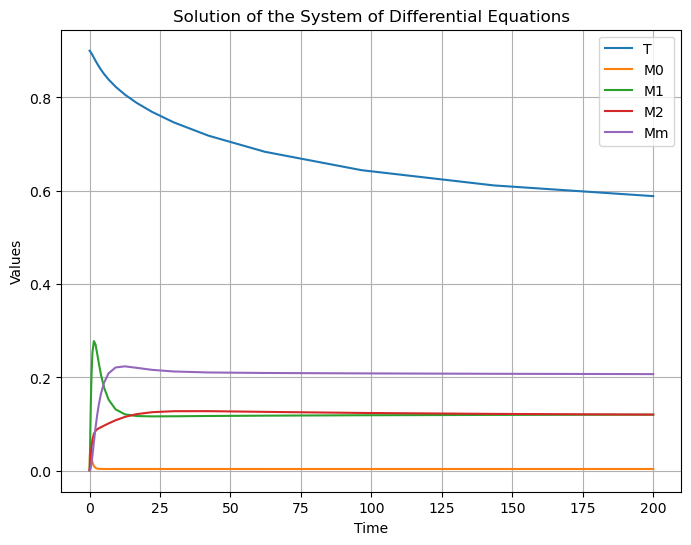

In [2]:
# Define the system of differential equations
def equations(t, y, pT, h, f, dT, r1, r2, p0, g, d0, alpha01, alpha02, alpha10, alpha20, b, d1, alpha1m, d2, 
              alpham2, dm, alpham1,alpha2m, alpha12, alpha21):
    T, M0, M1, M2, Mm = y

    f0 = pT * T * (1 - T) * (h - r1 * M1 + r2 * M2) - dT * T
    f1 = (p0 * T * (1 - (M0 + M1 + M2 + Mm) / f) * (1 + g * M1) +
          alpha10 * M1 + alpha20 * M2 -
          d0 * M0 - alpha01 * M0 -
          alpha02 * M0 * (1 + b * T / (T + f)))
    f2 = (-d1 * M1 - alpha10 * M1 +
          alpha01 * M0 + alpha21 * M2 + alpham1 * Mm -
          (alpha12 * M1 + alpha1m * M1) * (1 + b * T / (T + f)))
    f3 = (-d2 * M2 - alpha20 * M2 - alpha21 * M2 - alpha2m * M2 +
          (alpha02 * M0 + alpha12 * M1 + alpham2 * Mm) * (1 + b * T / (T + f)))
    f4 = (-dm * Mm - alpham1 * Mm + alpha2m * M2 +
          (alpha1m * M1 - alpham2 * Mm) * (1 + b * T / (T + f)))

    return [f0, f1, f2, f3, f4]

# Define the time span
t_span = (0, 200)  # Define the start and end time

# Define initial conditions [T0, M0_0, M1_0, M2_0, Mm_0]
T0 = .9  # initial tumor burden (scaled volume)
M00 = .0003  # initial M0
M10 = .001  # initial M1
M20 = .001  # initial M2
Mm0 = 0  # initial Mm
initial_conditions = [T0, M00, M10, M20, Mm0]


#  baseline parameter value 
pT_val = .23
h_val = .1
f_val = .5
dT_val = .01
r1_val = 1
r2_val = 1
p0_val = .7
g_val = 1
d0_val = .1
# alpha01 = 1 replace with bistable value
# alpha02 = .1 replace with bistable value
alpha10_val = .0001
alpha20_val = .0001
b_val = 2
d1_val = .1
# alpha1m = .001 replace with bistable value
d2_val = .1
# alpham2 = .01 replace with bistable value
dm_val = .1

# Case 3 original bistable (medium/low) -- commented out originals above
alpham2_val = .01
alpha02_val = 1
alpha1m_val = .1
alpha01_val = 10

# originally assume these are zero
alpham1_val = 0
alpha2m_val = 0
alpha12_val = 0
alpha21_val = 0




# Define parameters
params = (pT_val, h_val, f_val, dT_val, r1_val, r2_val, p0_val, g_val, d0_val, alpha01_val,
          alpha02_val, alpha10_val, alpha20_val, b_val, d1_val, alpha1m_val, d2_val, alpham2_val, dm_val, alpham1_val,
         alpha2m_val, alpha12_val, alpha21_val)

start = time.time() # time process

# Solve the system of differential equations with parameters
sol = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')

end = time.time()
print(end-start)

# Plot the solution
plt.figure(figsize=(8, 6))
plt.plot(sol.t, sol.y.T)
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Solution of the System of Differential Equations')
plt.legend(['T', 'M0', 'M1', 'M2', 'Mm'])
plt.grid(True)
plt.show()


# Implement GSA

## Bistable Case Medium/Low (Case 3 in Matlab Code)

### Sample Parameters
Vary parameters between 50% and 150% of baseline values for the bistable case.

In [3]:
#  baseline parameter value 
pT = .23
h = .1
f = .5
dT = .01
r1 = 1
r2 = 1
p0 = .7
g = 1
d0 = .1
# alpha01 = 1 replace with bistable value
# alpha02 = .1 replace with bistable value
alpha10 = .0001
alpha20 = .0001
b = 2
d1 = .1
# alpha1m = .001 replace with bistable value
d2 = .1
# alpham2 = .01 replace with bistable value
dm = .1

# Case 3 original bistable (medium/low) -- commented out originals above
alpham2 = .01
alpha02 = 1
alpha1m = .1
alpha01 = 10

# originally assume these are zero
#alpham1 = 0
#alpha2m = 0
#alpha12 = 0
#alpha21 = 0

# vary parameters 50% in each direction,  If the baseline value is zero, sample from [0, .01]
vl =.5
vr = 1.5

         
problem = {
    'num_vars': 23,
    'names': ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21'],
    'bounds': [[vl*pT, vr*pT],  
               [vl*h, vr*h],  
               [vl*f, vr*f],  
               [vl*dT, vr*dT],
               [vl*r1, vr*r1],
               [vl*r2, vr*r2],
               [vl*p0, vr*p0],
               [vl*g, vr*g],
               [vl*d0, vr*d0],
               [vl*alpha01, vr*alpha01],
               [vl*alpha02, vr*alpha02],
               [vl*alpha10, vr*alpha10],
               [vl*alpha20, vr*alpha20],
               [vl*b, vr*b],
               [vl*d1, vr*d1],
               [vl*alpha1m, vr*alpha1m],
               [vl*d2, vr*d2],
               [vl*alpham2, vr*alpham2],
               [vl*dm, vr*dm],
               [0,.01], # alpham1
               [0,.01], # alpham2
               [0,.01], # alpha12
               [0,.01]] # alpha21              
}
# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 2048, calc_second_order=True) # depreciation warning
# print(param_values.shape) # check dimensions



/tmp/ipykernel_8831/1527831082.py:68: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2048, calc_second_order=True) # depreciation warning


Make array to hold outcome of interest (steady state of one variable of ODE solution, ratio, etc.)  One spot for each parameter value.

In [4]:
Y = np.zeros([param_values.shape[0]]) # make array to hold outcome of interest 
print(Y.shape)

(98304,)


### Solve ODE System for Each Parameter Set Sampled
Store the ratio of M1 to M2 macraophages in the steady state (last time step) as the outcome of interest.

In [5]:
start = time.time() # time process

for i in range(param_values.shape[0]): # loop through each row of parameter array

    # set parameter value based on sample
    
    pT_val = param_values[i,0]
    h_val = param_values[i,1]
    f_val = param_values[i,2]
    dT_val = param_values[i,3]
    r1_val = param_values[i,4]
    r2_val = param_values[i,5]
    p0_val = param_values[i,6]
    g_val = param_values[i,7]
    d0_val = param_values[i,8]
    alpha01_val = param_values[i,9]
    alpha02_val = param_values[i,10]
    alpha10_val = param_values[i,11]
    alpha20_val = param_values[i,12]
    b_val = param_values[i,13]
    d1_val = param_values[i,14]
    alpha1m_val = param_values[i,15]
    d2_val = param_values[i,16]
    alpham2_val = param_values[i,17]
    dm_val = param_values[i,18]
    alpham1_val = param_values[i,19]
    alpha2m_val = param_values[i,20]
    alpha12_val = param_values[i,21]
    alpha21_val = param_values[i,22]
    
    
    
    # Define parameters to pass to ODE solver
    params = (pT_val, h_val, f_val, dT_val, r1_val, r2_val, p0_val, g_val, d0_val, alpha01_val,
          alpha02_val, alpha10_val, alpha20_val, b_val, d1_val, alpha1m_val, d2_val, alpham2_val, dm_val, alpham1_val,
         alpha2m_val, alpha12_val, alpha21_val)

    # Solve the system of differential equations with parameters
    # solve_ivp(system, (t0,tf), y0, method)
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')

    # note: soln.t is the time points, soln.y attribute contains values of solution at corresponding time points
    M1 = soln.y[:,2]
    M2 = soln.y[:,3]
    # outcome of interest ratio of variables at last time step (at steady state)
    Y[i] = M1[-1]/M2[-1]

end = time.time()
print(end-start)

485.06572818756104


### Perform Sobol Sensitivity Analysis.
Note: sobol.analyze will compute first, second, and total-order indices. Si is a Python dictionary with the keys "S1", "S2", "ST", "S1_conf", "S2_conf", and "ST_conf".

In [6]:
Si = sobol.analyze(problem, Y)
# see results on console for 1st order and total sensitivities
print(Si['S1'])  
print(Si['ST'])

[-8.00246819e-07  8.83091128e-07  3.45153033e-02  3.43097937e-06
  1.53041693e-08  1.20031585e-08  6.14705099e-01 -1.25707418e-04
  9.87808127e-05  2.00101694e-01  8.88808055e-02 -1.23047458e-07
  1.66638768e-08  2.85420799e-02  4.54625980e-05  1.93039291e-05
 -3.81055761e-06  1.87848712e-06  1.16052841e-06 -1.07409643e-06
  1.05955074e-03  1.01034030e-05 -1.04896139e-06]
[6.94853055e-08 6.49496938e-08 3.97702781e-02 1.13723695e-06
 6.97582309e-11 1.58703962e-12 6.29203928e-01 1.95872510e-04
 1.26902289e-04 2.24241300e-01 9.84056101e-02 8.82830171e-11
 2.53401416e-12 3.37186943e-02 5.36963337e-05 2.06519314e-04
 1.06182692e-06 2.67605995e-07 4.57489957e-06 4.80936441e-08
 1.06752327e-03 1.02298113e-06 1.85268593e-08]


### Plot Sobol Sensitivity Indices

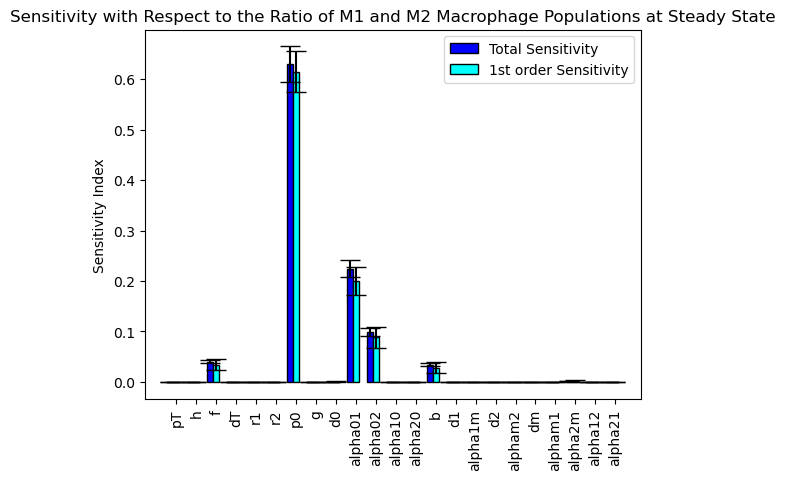

In [7]:
 # Si.get('S1') # returns array with values for S1    
A = Si.get('S1')
# change array to list for plotting
S1_values = A.tolist() # list of S1 values
# get ST values
B = Si.get('ST')
# change array to list for plotting
ST_values = B.tolist()
 # get confidence intervals for ST
C = Si.get('ST_conf')
# change array to list for plotting
STconf_values = C.tolist()
# get confidence intervals for S1
D = Si.get('S1_conf')
# change array to list for plotting
S1conf_values = D.tolist()
 
 # width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars-- ST
bars1 = ST_values
 
# Choose the height of the cyan bars-- S1
bars2 = S1_values
 
# Choose the height of the error bars (bars1)-- CI for ST
yer1 = STconf_values
# Choose the height of the error bars (bars2)-- CI for S1
yer2 = S1conf_values
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

f = plt.figure()
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='Total Sensitivity')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='1st order Sensitivity')
 
## general layout
# 
plt.xticks([r + barWidth for r in range(len(bars1))], ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0',
                                                       'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b', 'd1',
                                                       'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m',
                                                       'alpha12', 'alpha21'],rotation='vertical')
plt.ylabel('Sensitivity Index')
plt.legend()
plt.title('Sensitivity with Respect to the Ratio of M1 and M2 Macrophage Populations at Steady State') # instead, add figure caption in Latex


# view and save figure (saving will allow you to put into your paper)
plt.show()
#f.savefig("macrophagetumor_bistable.pdf",bbox='tight')

## Case 1 (Low)
This case alters parameters $\alpha_{m2}$, $\alpha_{02}$, $\alpha_{1m}$, and $\alpha_{01}$.

In [8]:

#  baseline parameter value 
pT = .23
h = .1
f = .5
dT = .01
r1 = 1
r2 = 1
p0 = .7
g = 1
d0 = .1
# alpha01 = 1 replace with low value
# alpha02 = .1 replace with low value
alpha10 = .0001
alpha20 = .0001
b = 2
d1 = .1
# alpha1m = .001 replace with low value
d2 = .1
# alpham2 = .01 replace with low value
dm = .1

# Case 1 (low) -- commented out originals above
alpham2=0.01
alpha02=0.1
alpha1m=0.001
alpha01=1

# vary parameters 50% in each direction,  If the baseline value is zero, sample from [0, .01]
vl =.5
vr = 1.5

         
problem = {
    'num_vars': 23,
    'names': ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21'],
    'bounds': [[vl*pT, vr*pT],  
               [vl*h, vr*h],  
               [vl*f, vr*f],  
               [vl*dT, vr*dT],
               [vl*r1, vr*r1],
               [vl*r2, vr*r2],
               [vl*p0, vr*p0],
               [vl*g, vr*g],
               [vl*d0, vr*d0],
               [vl*alpha01, vr*alpha01],
               [vl*alpha02, vr*alpha02],
               [vl*alpha10, vr*alpha10],
               [vl*alpha20, vr*alpha20],
               [vl*b, vr*b],
               [vl*d1, vr*d1],
               [vl*alpha1m, vr*alpha1m],
               [vl*d2, vr*d2],
               [vl*alpham2, vr*alpham2],
               [vl*dm, vr*dm],
               [0,.01], # alpham1
               [0,.01], # alpham2
               [0,.01], # alpha12
               [0,.01]] # alpha21              
}
# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 2048, calc_second_order=True) # depreciation warning
Y = np.zeros([param_values.shape[0]]) # make array to hold outcome of interest (e.g, ratio of M1/M2 macrophages) 

start = time.time() # time process

for i in range(param_values.shape[0]): # loop through each row of parameter array

    # set parameter value based on sample
    
    pT_val = param_values[i,0]
    h_val = param_values[i,1]
    f_val = param_values[i,2]
    dT_val = param_values[i,3]
    r1_val = param_values[i,4]
    r2_val = param_values[i,5]
    p0_val = param_values[i,6]
    g_val = param_values[i,7]
    d0_val = param_values[i,8]
    alpha01_val = param_values[i,9]
    alpha02_val = param_values[i,10]
    alpha10_val = param_values[i,11]
    alpha20_val = param_values[i,12]
    b_val = param_values[i,13]
    d1_val = param_values[i,14]
    alpha1m_val = param_values[i,15]
    d2_val = param_values[i,16]
    alpham2_val = param_values[i,17]
    dm_val = param_values[i,18]
    alpham1_val = param_values[i,19]
    alpha2m_val = param_values[i,20]
    alpha12_val = param_values[i,21]
    alpha21_val = param_values[i,22]
    
    
    
    # Define parameters to pass to ODE solver
    params = (pT_val, h_val, f_val, dT_val, r1_val, r2_val, p0_val, g_val, d0_val, alpha01_val,
          alpha02_val, alpha10_val, alpha20_val, b_val, d1_val, alpha1m_val, d2_val, alpham2_val, dm_val, alpham1_val,
         alpha2m_val, alpha12_val, alpha21_val)

    # Solve the system of differential equations with parameters
    # solve_ivp(system, (t0,tf), y0, method)
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')

    # note: soln.t is the time points, soln.y attribute contains values of solution at corresponding time points
    M1 = soln.y[:,2]
    M2 = soln.y[:,3]
    # outcome of interest ratio of variables at last time step (at steady state)
    Y[i] = M1[-1]/M2[-1]

end = time.time()
print(end-start)



/tmp/ipykernel_8831/3413455533.py:64: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2048, calc_second_order=True) # depreciation warning


826.3666019439697


In [9]:
Si = sobol.analyze(problem, Y)
# see results on console for 1st order and total sensitivities
print(Si['S1'])  
print(Si['ST'])

[-3.55958350e-06 -1.08062798e-05  2.41582148e-01  9.32423528e-06
 -2.01414506e-08  6.77560723e-07  2.06309611e-01  2.77387157e-03
  2.68321421e-03  1.63147534e-01  8.96005661e-03 -1.29321787e-06
  3.09577740e-08  2.26138175e-02  3.17930005e-04  3.35315330e-02
  3.44992280e-05 -9.52166600e-06  3.46554794e-05 -8.12004179e-06
  2.63629060e-01 -4.17653121e-06  2.76201331e-06]
[1.44660624e-06 1.45690255e-06 2.50336326e-01 2.57018134e-05
 5.45697434e-10 2.21712401e-10 2.24131234e-01 2.53673652e-03
 2.31841822e-03 1.89214736e-01 1.37014805e-02 1.09664682e-09
 5.36560749e-11 2.52960289e-02 5.88707759e-04 4.14860941e-02
 2.79759464e-05 1.91472802e-06 3.54284092e-05 3.59117077e-07
 2.97507012e-01 8.81663501e-06 8.78102682e-08]


### Plot Sobol Indices

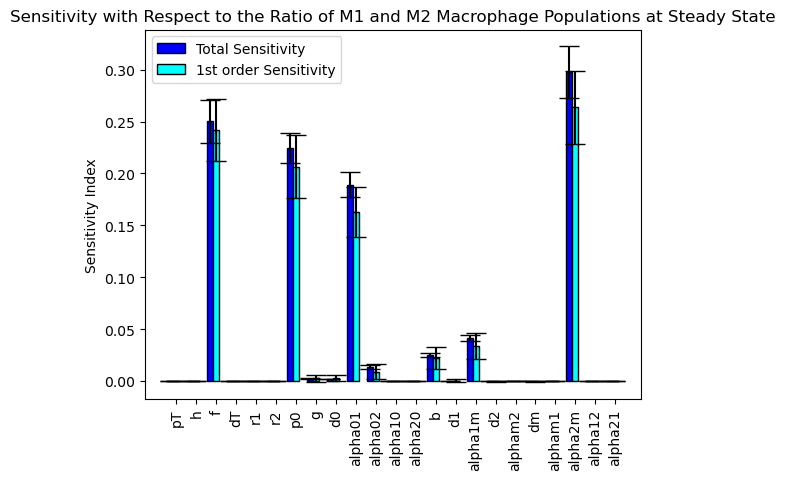

In [10]:
 # Si.get('S1') # returns array with values for S1    
A = Si.get('S1')
# change array to list for plotting
S1_values = A.tolist() # list of S1 values
# get ST values
B = Si.get('ST')
# change array to list for plotting
ST_values = B.tolist()
 # get confidence intervals for ST
C = Si.get('ST_conf')
# change array to list for plotting
STconf_values = C.tolist()
# get confidence intervals for S1
D = Si.get('S1_conf')
# change array to list for plotting
S1conf_values = D.tolist()
 
 # width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars-- ST
bars1 = ST_values
 
# Choose the height of the cyan bars-- S1
bars2 = S1_values
 
# Choose the height of the error bars (bars1)-- CI for ST
yer1 = STconf_values
# Choose the height of the error bars (bars2)-- CI for S1
yer2 = S1conf_values
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

f = plt.figure()
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='Total Sensitivity')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='1st order Sensitivity')
 
## general layout
# 
plt.xticks([r + barWidth for r in range(len(bars1))], ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0',
                                                       'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b', 'd1',
                                                       'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m',
                                                       'alpha12', 'alpha21'],rotation='vertical')
plt.ylabel('Sensitivity Index')
plt.legend()
plt.title('Sensitivity with Respect to the Ratio of M1 and M2 Macrophage Populations at Steady State') # instead, add figure caption in Latex


# view and save figure (saving will allow you to put into your paper)
plt.show()
#f.savefig("macrophagetumor_low.pdf",bbox='tight')

## Case 2 (Bistable)
Change $\alpha_{m2}$, $\alpha_{02}$, $\alpha_{1m}$, $\alpha_{01}$.

/tmp/ipykernel_8831/1751828225.py:57: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2048, calc_second_order=True) # depreciation warning


445.6455280780792
[-7.81662313e-06 -6.71593610e-06  5.45344531e-01  2.12008636e-05
 -1.21217137e-07  1.57941844e-07  3.50344218e-01  3.78995939e-03
  3.70616215e-03  2.47602971e-02  1.85650182e-02 -1.64755031e-07
  4.49725503e-08  1.81780704e-02  1.08917341e-03  1.06165223e-02
  1.01449720e-05  1.43663588e-06  7.62990539e-05 -5.18777606e-06
  9.04690393e-04 -2.00685228e-06 -1.32642583e-05]
[2.40309337e-06 2.41714586e-06 5.60160855e-01 4.23178696e-05
 7.13485884e-10 3.34536452e-10 3.63746531e-01 3.19783009e-03
 3.49823146e-03 3.64901822e-02 1.96266696e-02 2.07672058e-09
 2.32331895e-11 2.10962660e-02 1.29099439e-03 1.11881350e-02
 5.96737361e-06 3.58555478e-06 5.29896941e-05 8.53073852e-07
 1.20497262e-03 4.45466736e-05 8.16887999e-07]


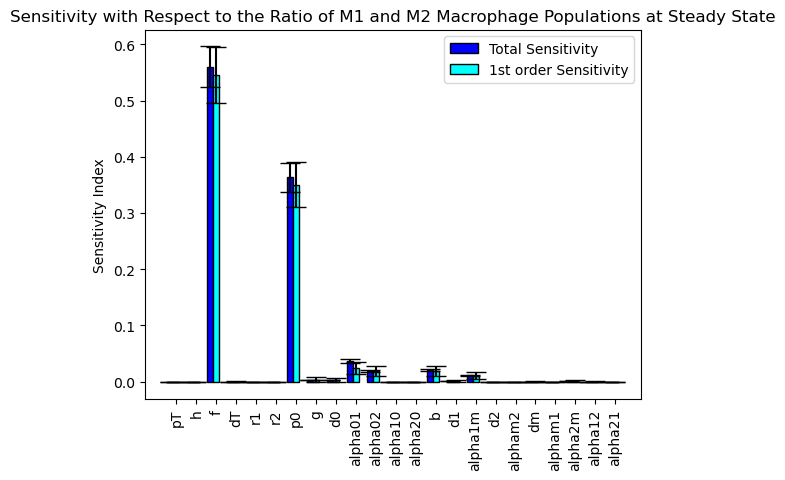

In [11]:
#  baseline parameter value 
pT = .23
h = .1
f = .5
dT = .01
r1 = 1
r2 = 1
p0 = .7
g = 1
d0 = .1
alpha10 = .0001
alpha20 = .0001
b = 2
d1 = .1
d2 = .1
dm = .1
# Case 2 (bistable) 
alpham2=0.01
alpha02=0.1
alpha1m=0.1
alpha01=1

# vary parameters 50% in each direction,  If the baseline value is zero, sample from [0, .01]
vl =.5
vr = 1.5

         
problem = {
    'num_vars': 23,
    'names': ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21'],
    'bounds': [[vl*pT, vr*pT],  
               [vl*h, vr*h],  
               [vl*f, vr*f],  
               [vl*dT, vr*dT],
               [vl*r1, vr*r1],
               [vl*r2, vr*r2],
               [vl*p0, vr*p0],
               [vl*g, vr*g],
               [vl*d0, vr*d0],
               [vl*alpha01, vr*alpha01],
               [vl*alpha02, vr*alpha02],
               [vl*alpha10, vr*alpha10],
               [vl*alpha20, vr*alpha20],
               [vl*b, vr*b],
               [vl*d1, vr*d1],
               [vl*alpha1m, vr*alpha1m],
               [vl*d2, vr*d2],
               [vl*alpham2, vr*alpham2],
               [vl*dm, vr*dm],
               [0,.01], # alpham1
               [0,.01], # alpham2
               [0,.01], # alpha12
               [0,.01]] # alpha21              
}
# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 2048, calc_second_order=True) # depreciation warning
Y = np.zeros([param_values.shape[0]]) # make array to hold outcome of interest (e.g, ratio of M1/M2 macrophages) 

start = time.time() # time process

for i in range(param_values.shape[0]): # loop through each row of parameter array

    # set parameter value based on sample
    
    pT_val = param_values[i,0]
    h_val = param_values[i,1]
    f_val = param_values[i,2]
    dT_val = param_values[i,3]
    r1_val = param_values[i,4]
    r2_val = param_values[i,5]
    p0_val = param_values[i,6]
    g_val = param_values[i,7]
    d0_val = param_values[i,8]
    alpha01_val = param_values[i,9]
    alpha02_val = param_values[i,10]
    alpha10_val = param_values[i,11]
    alpha20_val = param_values[i,12]
    b_val = param_values[i,13]
    d1_val = param_values[i,14]
    alpha1m_val = param_values[i,15]
    d2_val = param_values[i,16]
    alpham2_val = param_values[i,17]
    dm_val = param_values[i,18]
    alpham1_val = param_values[i,19]
    alpha2m_val = param_values[i,20]
    alpha12_val = param_values[i,21]
    alpha21_val = param_values[i,22]
    
    
    
    # Define parameters to pass to ODE solver
    params = (pT_val, h_val, f_val, dT_val, r1_val, r2_val, p0_val, g_val, d0_val, alpha01_val,
          alpha02_val, alpha10_val, alpha20_val, b_val, d1_val, alpha1m_val, d2_val, alpham2_val, dm_val, alpham1_val,
         alpha2m_val, alpha12_val, alpha21_val)

    # Solve the system of differential equations with parameters
    # solve_ivp(system, (t0,tf), y0, method)
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')

    # note: soln.t is the time points, soln.y attribute contains values of solution at corresponding time points
    M1 = soln.y[:,2]
    M2 = soln.y[:,3]
    # outcome of interest ratio of variables at last time step (at steady state)
    Y[i] = M1[-1]/M2[-1]

end = time.time()
print(end-start)


Si = sobol.analyze(problem, Y)
# see results on console for 1st order and total sensitivities
print(Si['S1'])  
print(Si['ST'])

 # Si.get('S1') # returns array with values for S1    
A = Si.get('S1')
# change array to list for plotting
S1_values = A.tolist() # list of S1 values
# get ST values
B = Si.get('ST')
# change array to list for plotting
ST_values = B.tolist()
 # get confidence intervals for ST
C = Si.get('ST_conf')
# change array to list for plotting
STconf_values = C.tolist()
# get confidence intervals for S1
D = Si.get('S1_conf')
# change array to list for plotting
S1conf_values = D.tolist()
 
 # width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars-- ST
bars1 = ST_values
 
# Choose the height of the cyan bars-- S1
bars2 = S1_values
 
# Choose the height of the error bars (bars1)-- CI for ST
yer1 = STconf_values
# Choose the height of the error bars (bars2)-- CI for S1
yer2 = S1conf_values
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

f = plt.figure()
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='Total Sensitivity')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='1st order Sensitivity')
 
## general layout
# 
plt.xticks([r + barWidth for r in range(len(bars1))], ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0',
                                                       'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b', 'd1',
                                                       'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m',
                                                       'alpha12', 'alpha21'],rotation='vertical')
plt.ylabel('Sensitivity Index')
plt.legend()
plt.title('Sensitivity with Respect to the Ratio of M1 and M2 Macrophage Populations at Steady State') # instead, add figure caption in Latex


# view and save figure (saving will allow you to put into your paper)
plt.show()
#f.savefig("macrophagetumor_bistableCase2.pdf",bbox='tight')

## Case 4 (Bistable)
Change $\alpha_{m2}$, $\alpha_{02}$, $\alpha_{1m}$, $\alpha_{01}$, $\alpha_{20}$

/tmp/ipykernel_8831/1003422717.py:58: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2048, calc_second_order=True) # depreciation warning


450.4625871181488
[ 6.82672407e-08 -1.35068927e-06  1.43569203e-01  1.65968654e-05
 -8.30882295e-09  2.11028029e-07  4.28036651e-01  3.38683173e-04
  8.98758406e-04  3.23152903e-02  1.24824166e-01 -5.26274284e-07
  2.63251854e-04  6.22789364e-02  2.74734808e-05  1.03016901e-02
  1.50996709e-04  5.96911689e-06  2.14157447e-05  9.64758807e-07
  1.44419007e-01  2.07595448e-05  4.80762467e-06]
[5.62783660e-07 5.72427995e-07 1.48315328e-01 1.02071602e-05
 1.14604961e-11 1.78990648e-10 4.35771576e-01 2.27979748e-04
 7.74438695e-04 5.27178676e-02 1.50075534e-01 5.55381170e-11
 3.49627368e-04 7.39583714e-02 2.30450837e-05 1.25820239e-02
 1.77256595e-04 5.93329885e-07 1.06030138e-05 1.06917512e-07
 1.72442616e-01 3.71718291e-07 3.82106610e-07]


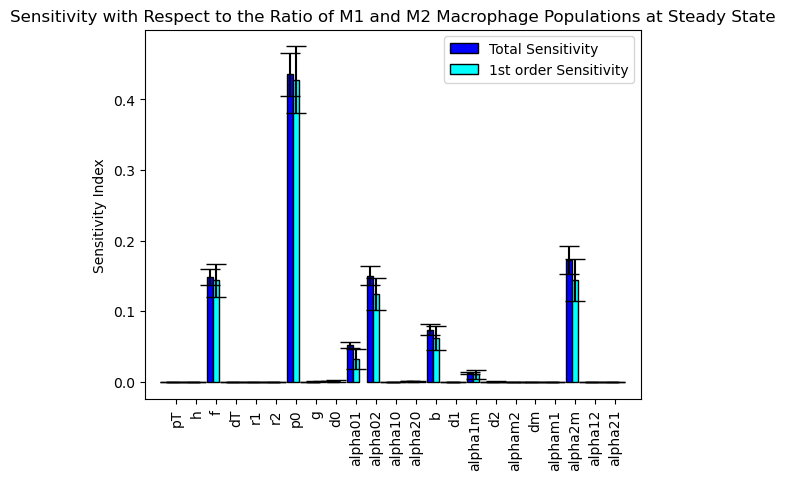

In [12]:
#  baseline parameter value 
pT = .23
h = .1
f = .5
dT = .01
r1 = 1
r2 = 1
p0 = .7
g = 1
d0 = .1
alpha10 = .0001
#alpha20 = .0001
b = 2
d1 = .1
d2 = .1
dm = .1
# Case 4 (bistable) 
alpham2=0.01
alpha02=1
alpha1m=0.001
alpha01=1
alpha20 = .1

# vary parameters 50% in each direction,  If the baseline value is zero, sample from [0, .01]
vl =.5
vr = 1.5

         
problem = {
    'num_vars': 23,
    'names': ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21'],
    'bounds': [[vl*pT, vr*pT],  
               [vl*h, vr*h],  
               [vl*f, vr*f],  
               [vl*dT, vr*dT],
               [vl*r1, vr*r1],
               [vl*r2, vr*r2],
               [vl*p0, vr*p0],
               [vl*g, vr*g],
               [vl*d0, vr*d0],
               [vl*alpha01, vr*alpha01],
               [vl*alpha02, vr*alpha02],
               [vl*alpha10, vr*alpha10],
               [vl*alpha20, vr*alpha20],
               [vl*b, vr*b],
               [vl*d1, vr*d1],
               [vl*alpha1m, vr*alpha1m],
               [vl*d2, vr*d2],
               [vl*alpham2, vr*alpham2],
               [vl*dm, vr*dm],
               [0,.01], # alpham1
               [0,.01], # alpham2
               [0,.01], # alpha12
               [0,.01]] # alpha21              
}
# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 2048, calc_second_order=True) # depreciation warning
Y = np.zeros([param_values.shape[0]]) # make array to hold outcome of interest (e.g, ratio of M1/M2 macrophages) 

start = time.time() # time process

for i in range(param_values.shape[0]): # loop through each row of parameter array

    # set parameter value based on sample
    
    pT_val = param_values[i,0]
    h_val = param_values[i,1]
    f_val = param_values[i,2]
    dT_val = param_values[i,3]
    r1_val = param_values[i,4]
    r2_val = param_values[i,5]
    p0_val = param_values[i,6]
    g_val = param_values[i,7]
    d0_val = param_values[i,8]
    alpha01_val = param_values[i,9]
    alpha02_val = param_values[i,10]
    alpha10_val = param_values[i,11]
    alpha20_val = param_values[i,12]
    b_val = param_values[i,13]
    d1_val = param_values[i,14]
    alpha1m_val = param_values[i,15]
    d2_val = param_values[i,16]
    alpham2_val = param_values[i,17]
    dm_val = param_values[i,18]
    alpham1_val = param_values[i,19]
    alpha2m_val = param_values[i,20]
    alpha12_val = param_values[i,21]
    alpha21_val = param_values[i,22]
    
    
    
    # Define parameters to pass to ODE solver
    params = (pT_val, h_val, f_val, dT_val, r1_val, r2_val, p0_val, g_val, d0_val, alpha01_val,
          alpha02_val, alpha10_val, alpha20_val, b_val, d1_val, alpha1m_val, d2_val, alpham2_val, dm_val, alpham1_val,
         alpha2m_val, alpha12_val, alpha21_val)

    # Solve the system of differential equations with parameters
    # solve_ivp(system, (t0,tf), y0, method)
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')

    # note: soln.t is the time points, soln.y attribute contains values of solution at corresponding time points
    M1 = soln.y[:,2]
    M2 = soln.y[:,3]
    # outcome of interest ratio of variables at last time step (at steady state)
    Y[i] = M1[-1]/M2[-1]

end = time.time()
print(end-start)


Si = sobol.analyze(problem, Y)
# see results on console for 1st order and total sensitivities
print(Si['S1'])  
print(Si['ST'])

 # Si.get('S1') # returns array with values for S1    
A = Si.get('S1')
# change array to list for plotting
S1_values = A.tolist() # list of S1 values
# get ST values
B = Si.get('ST')
# change array to list for plotting
ST_values = B.tolist()
 # get confidence intervals for ST
C = Si.get('ST_conf')
# change array to list for plotting
STconf_values = C.tolist()
# get confidence intervals for S1
D = Si.get('S1_conf')
# change array to list for plotting
S1conf_values = D.tolist()
 
 # width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars-- ST
bars1 = ST_values
 
# Choose the height of the cyan bars-- S1
bars2 = S1_values
 
# Choose the height of the error bars (bars1)-- CI for ST
yer1 = STconf_values
# Choose the height of the error bars (bars2)-- CI for S1
yer2 = S1conf_values
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

f = plt.figure()
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='Total Sensitivity')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='1st order Sensitivity')
 
## general layout
# 
plt.xticks([r + barWidth for r in range(len(bars1))], ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0',
                                                       'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b', 'd1',
                                                       'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m',
                                                       'alpha12', 'alpha21'],rotation='vertical')
plt.ylabel('Sensitivity Index')
plt.legend()
plt.title('Sensitivity with Respect to the Ratio of M1 and M2 Macrophage Populations at Steady State') # instead, add figure caption in Latex


# view and save figure (saving will allow you to put into your paper)
plt.show()
#f.savefig("macrophageGSACase4.pdf)

## Case 5 (Bistable)
Change $\alpha_{m2}$, $\alpha_{02}$, $\alpha_{1m}$, $\alpha_{01}$.

/tmp/ipykernel_8831/356513736.py:57: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2048, calc_second_order=True) # depreciation warning


439.035769701004
[-2.57035249e-06 -9.46631098e-06  2.68593830e-01  2.65167571e-05
  1.34102150e-07  4.11369486e-08  4.62330356e-01  1.50436370e-03
  2.33629045e-03  1.17923758e-01  4.08463458e-02 -1.41042995e-06
  1.38213882e-09  1.31403324e-02  1.90197627e-06 -2.76451956e-04
  1.75094554e-04  6.30919910e-06  3.68634922e-05 -1.07799370e-06
  8.85395517e-03  7.94167494e-06  5.05550049e-06]
[1.37800808e-06 1.38009938e-06 2.76735766e-01 2.44955492e-05
 7.25137455e-11 1.14623968e-10 4.74089396e-01 1.07805171e-03
 1.96872859e-03 1.56515282e-01 7.30453314e-02 3.40688858e-10
 4.72905691e-10 3.13827798e-02 1.59490792e-04 5.45433780e-03
 2.33565176e-04 1.29438465e-06 2.33701915e-05 2.36255878e-07
 6.04225217e-02 6.97351529e-07 2.45141125e-07]


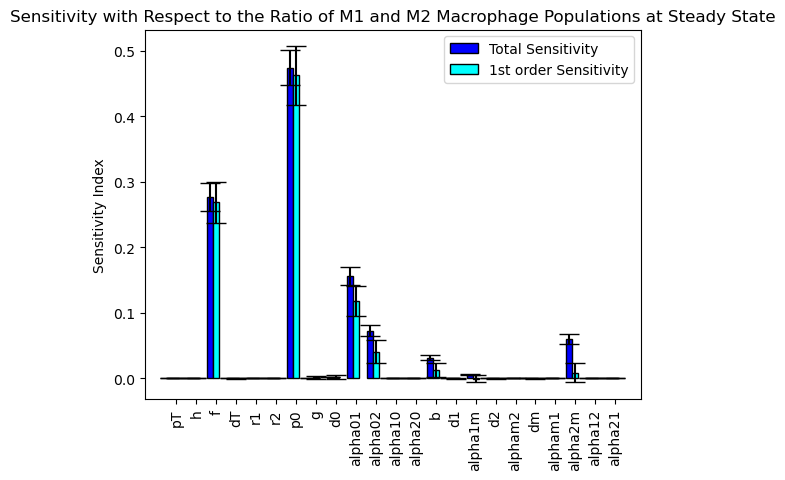

In [13]:
#  baseline parameter value 
pT = .23
h = .1
f = .5
dT = .01
r1 = 1
r2 = 1
p0 = .7
g = 1
d0 = .1
alpha10 = .0001
alpha20 = .0001
b = 2
d1 = .1
d2 = .1
dm = .1
# Case 2 (bistable) 
alpham2=0.01
alpha02=0.5
alpha1m=0.001
alpha01=1

# vary parameters 50% in each direction,  If the baseline value is zero, sample from [0, .01]
vl =.5
vr = 1.5

         
problem = {
    'num_vars': 23,
    'names': ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21'],
    'bounds': [[vl*pT, vr*pT],  
               [vl*h, vr*h],  
               [vl*f, vr*f],  
               [vl*dT, vr*dT],
               [vl*r1, vr*r1],
               [vl*r2, vr*r2],
               [vl*p0, vr*p0],
               [vl*g, vr*g],
               [vl*d0, vr*d0],
               [vl*alpha01, vr*alpha01],
               [vl*alpha02, vr*alpha02],
               [vl*alpha10, vr*alpha10],
               [vl*alpha20, vr*alpha20],
               [vl*b, vr*b],
               [vl*d1, vr*d1],
               [vl*alpha1m, vr*alpha1m],
               [vl*d2, vr*d2],
               [vl*alpham2, vr*alpham2],
               [vl*dm, vr*dm],
               [0,.01], # alpham1
               [0,.01], # alpham2
               [0,.01], # alpha12
               [0,.01]] # alpha21              
}
# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 2048, calc_second_order=True) # depreciation warning
Y = np.zeros([param_values.shape[0]]) # make array to hold outcome of interest (e.g, ratio of M1/M2 macrophages) 

start = time.time() # time process

for i in range(param_values.shape[0]): # loop through each row of parameter array

    # set parameter value based on sample
    
    pT_val = param_values[i,0]
    h_val = param_values[i,1]
    f_val = param_values[i,2]
    dT_val = param_values[i,3]
    r1_val = param_values[i,4]
    r2_val = param_values[i,5]
    p0_val = param_values[i,6]
    g_val = param_values[i,7]
    d0_val = param_values[i,8]
    alpha01_val = param_values[i,9]
    alpha02_val = param_values[i,10]
    alpha10_val = param_values[i,11]
    alpha20_val = param_values[i,12]
    b_val = param_values[i,13]
    d1_val = param_values[i,14]
    alpha1m_val = param_values[i,15]
    d2_val = param_values[i,16]
    alpham2_val = param_values[i,17]
    dm_val = param_values[i,18]
    alpham1_val = param_values[i,19]
    alpha2m_val = param_values[i,20]
    alpha12_val = param_values[i,21]
    alpha21_val = param_values[i,22]
    
    
    
    # Define parameters to pass to ODE solver
    params = (pT_val, h_val, f_val, dT_val, r1_val, r2_val, p0_val, g_val, d0_val, alpha01_val,
          alpha02_val, alpha10_val, alpha20_val, b_val, d1_val, alpha1m_val, d2_val, alpham2_val, dm_val, alpham1_val,
         alpha2m_val, alpha12_val, alpha21_val)

    # Solve the system of differential equations with parameters
    # solve_ivp(system, (t0,tf), y0, method)
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')

    # note: soln.t is the time points, soln.y attribute contains values of solution at corresponding time points
    M1 = soln.y[:,2]
    M2 = soln.y[:,3]
    # outcome of interest ratio of variables at last time step (at steady state)
    Y[i] = M1[-1]/M2[-1]

end = time.time()
print(end-start)


Si = sobol.analyze(problem, Y)
# see results on console for 1st order and total sensitivities
print(Si['S1'])  
print(Si['ST'])

 # Si.get('S1') # returns array with values for S1    
A = Si.get('S1')
# change array to list for plotting
S1_values = A.tolist() # list of S1 values
# get ST values
B = Si.get('ST')
# change array to list for plotting
ST_values = B.tolist()
 # get confidence intervals for ST
C = Si.get('ST_conf')
# change array to list for plotting
STconf_values = C.tolist()
# get confidence intervals for S1
D = Si.get('S1_conf')
# change array to list for plotting
S1conf_values = D.tolist()
 
 # width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars-- ST
bars1 = ST_values
 
# Choose the height of the cyan bars-- S1
bars2 = S1_values
 
# Choose the height of the error bars (bars1)-- CI for ST
yer1 = STconf_values
# Choose the height of the error bars (bars2)-- CI for S1
yer2 = S1conf_values
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

f = plt.figure()
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='Total Sensitivity')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='1st order Sensitivity')
 
## general layout
# 
plt.xticks([r + barWidth for r in range(len(bars1))], ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0',
                                                       'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b', 'd1',
                                                       'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m',
                                                       'alpha12', 'alpha21'],rotation='vertical')
plt.ylabel('Sensitivity Index')
plt.legend()
plt.title('Sensitivity with Respect to the Ratio of M1 and M2 Macrophage Populations at Steady State') # instead, add figure caption in Latex


# view and save figure (saving will allow you to put into your paper)
plt.show()
#f.savefig("macrophagetumor_bistableCase2.pdf",bbox='tight')

## Case 6 (High)
Change $\alpha_{m2}=.01$, $\alpha_{02}=1$, $\alpha_{1m}=.001$, $\alpha_{01}=1$.

/tmp/ipykernel_8831/4148770500.py:57: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2048, calc_second_order=True) # depreciation warning


419.11714720726013
[ 2.37875603e-07 -1.83878107e-06  1.47150871e-01  1.70692534e-05
 -7.07693956e-09  2.21580082e-07  4.18272980e-01  3.50714177e-04
  9.35484871e-04  3.58399769e-02  1.25834232e-01 -5.43302769e-07
 -6.55987850e-08  6.28382643e-02  2.81644521e-05  1.03692619e-02
  1.43676482e-04  6.04290797e-06  2.08866280e-05  9.93535204e-07
  1.45397314e-01  2.08967824e-05  5.37822141e-06]
[5.81718093e-07 5.91907310e-07 1.51997587e-01 1.05600760e-05
 1.22491945e-11 1.94070358e-10 4.26415618e-01 2.42235840e-04
 8.06679855e-04 5.64565381e-02 1.51431395e-01 5.95154544e-11
 3.50394448e-10 7.48045614e-02 2.47758707e-05 1.26085715e-02
 1.72492784e-04 5.91212349e-07 1.05503783e-05 1.06448874e-07
 1.73201051e-01 3.35301521e-07 3.44241390e-07]


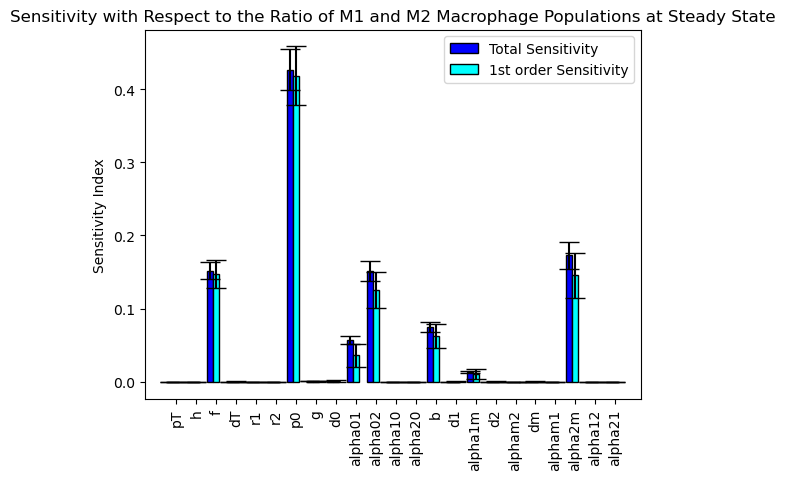

In [14]:
#  baseline parameter value 
pT = .23
h = .1
f = .5
dT = .01
r1 = 1
r2 = 1
p0 = .7
g = 1
d0 = .1
alpha10 = .0001
alpha20 = .0001
b = 2
d1 = .1
d2 = .1
dm = .1
# Case 2 (bistable) 
alpham2=0.01
alpha02= 1
alpha1m=0.001
alpha01=1

# vary parameters 50% in each direction,  If the baseline value is zero, sample from [0, .01]
vl =.5
vr = 1.5

         
problem = {
    'num_vars': 23,
    'names': ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21'],
    'bounds': [[vl*pT, vr*pT],  
               [vl*h, vr*h],  
               [vl*f, vr*f],  
               [vl*dT, vr*dT],
               [vl*r1, vr*r1],
               [vl*r2, vr*r2],
               [vl*p0, vr*p0],
               [vl*g, vr*g],
               [vl*d0, vr*d0],
               [vl*alpha01, vr*alpha01],
               [vl*alpha02, vr*alpha02],
               [vl*alpha10, vr*alpha10],
               [vl*alpha20, vr*alpha20],
               [vl*b, vr*b],
               [vl*d1, vr*d1],
               [vl*alpha1m, vr*alpha1m],
               [vl*d2, vr*d2],
               [vl*alpham2, vr*alpham2],
               [vl*dm, vr*dm],
               [0,.01], # alpham1
               [0,.01], # alpham2
               [0,.01], # alpha12
               [0,.01]] # alpha21              
}
# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 2048, calc_second_order=True) # depreciation warning
Y = np.zeros([param_values.shape[0]]) # make array to hold outcome of interest (e.g, ratio of M1/M2 macrophages) 

start = time.time() # time process

for i in range(param_values.shape[0]): # loop through each row of parameter array

    # set parameter value based on sample
    
    pT_val = param_values[i,0]
    h_val = param_values[i,1]
    f_val = param_values[i,2]
    dT_val = param_values[i,3]
    r1_val = param_values[i,4]
    r2_val = param_values[i,5]
    p0_val = param_values[i,6]
    g_val = param_values[i,7]
    d0_val = param_values[i,8]
    alpha01_val = param_values[i,9]
    alpha02_val = param_values[i,10]
    alpha10_val = param_values[i,11]
    alpha20_val = param_values[i,12]
    b_val = param_values[i,13]
    d1_val = param_values[i,14]
    alpha1m_val = param_values[i,15]
    d2_val = param_values[i,16]
    alpham2_val = param_values[i,17]
    dm_val = param_values[i,18]
    alpham1_val = param_values[i,19]
    alpha2m_val = param_values[i,20]
    alpha12_val = param_values[i,21]
    alpha21_val = param_values[i,22]
    
    
    
    # Define parameters to pass to ODE solver
    params = (pT_val, h_val, f_val, dT_val, r1_val, r2_val, p0_val, g_val, d0_val, alpha01_val,
          alpha02_val, alpha10_val, alpha20_val, b_val, d1_val, alpha1m_val, d2_val, alpham2_val, dm_val, alpham1_val,
         alpha2m_val, alpha12_val, alpha21_val)

    # Solve the system of differential equations with parameters
    # solve_ivp(system, (t0,tf), y0, method)
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')

    # note: soln.t is the time points, soln.y attribute contains values of solution at corresponding time points
    M1 = soln.y[:,2]
    M2 = soln.y[:,3]
    # outcome of interest ratio of variables at last time step (at steady state)
    Y[i] = M1[-1]/M2[-1]

end = time.time()
print(end-start)


Si = sobol.analyze(problem, Y)
# see results on console for 1st order and total sensitivities
print(Si['S1'])  
print(Si['ST'])

 # Si.get('S1') # returns array with values for S1    
A = Si.get('S1')
# change array to list for plotting
S1_values = A.tolist() # list of S1 values
# get ST values
B = Si.get('ST')
# change array to list for plotting
ST_values = B.tolist()
 # get confidence intervals for ST
C = Si.get('ST_conf')
# change array to list for plotting
STconf_values = C.tolist()
# get confidence intervals for S1
D = Si.get('S1_conf')
# change array to list for plotting
S1conf_values = D.tolist()
 
 # width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars-- ST
bars1 = ST_values
 
# Choose the height of the cyan bars-- S1
bars2 = S1_values
 
# Choose the height of the error bars (bars1)-- CI for ST
yer1 = STconf_values
# Choose the height of the error bars (bars2)-- CI for S1
yer2 = S1conf_values
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

f = plt.figure()
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='Total Sensitivity')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='1st order Sensitivity')
 
## general layout
# 
plt.xticks([r + barWidth for r in range(len(bars1))], ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0',
                                                       'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b', 'd1',
                                                       'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m',
                                                       'alpha12', 'alpha21'],rotation='vertical')
plt.ylabel('Sensitivity Index')
plt.legend()
plt.title('Sensitivity with Respect to the Ratio of M1 and M2 Macrophage Populations at Steady State') # instead, add figure caption in Latex


# view and save figure (saving will allow you to put into your paper)
plt.show()
#f.savefig("macrophagetumor_bistableCase6.pdf",bbox='tight')

## Case 7 (High)
Change $\alpha_{m2}=.01$, $\alpha_{02}=1.$, $\alpha_{1m}=.5$, $\alpha_{01}=1$.


/tmp/ipykernel_8831/2117005110.py:57: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, 2048, calc_second_order=True) # depreciation warning


422.01631784439087
[-4.00943863e-06  1.57576598e-06  1.93110047e-01 -2.29136562e-05
 -5.27383476e-08  5.39867201e-08  4.74713351e-01  3.85530387e-04
  6.58090629e-04  7.21393179e-04  3.91471410e-03 -9.37022840e-08
  1.47427801e-08  8.78387303e-02  3.57655080e-04  2.16685696e-01
  2.30351627e-06  5.42675474e-05  1.09956620e-04 -4.57571230e-06
  2.06169804e-05 -1.74514359e-05 -4.04376472e-06]
[6.14805948e-07 6.16253407e-07 1.95258016e-01 1.07230432e-05
 8.62010901e-11 6.54189143e-11 4.89908500e-01 2.79524348e-04
 6.71804321e-04 2.63872412e-03 3.42020331e-03 6.39776913e-10
 1.07123705e-12 9.68338740e-02 5.21817328e-04 2.31978742e-01
 2.55645066e-07 6.31215416e-06 1.04105711e-04 1.53137764e-06
 2.75148667e-05 2.37531705e-05 4.79904666e-07]


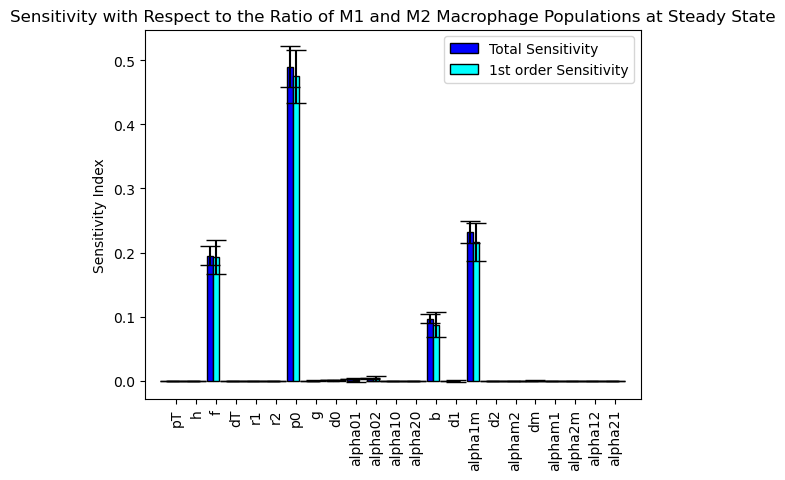

In [15]:
#  baseline parameter value 
pT = .23
h = .1
f = .5
dT = .01
r1 = 1
r2 = 1
p0 = .7
g = 1
d0 = .1
alpha10 = .0001
alpha20 = .0001
b = 2
d1 = .1
d2 = .1
dm = .1
# Case 2 (bistable) 
alpham2=0.01
alpha02= .1
alpha1m=0.5
alpha01=1

# vary parameters 50% in each direction,  If the baseline value is zero, sample from [0, .01]
vl =.5
vr = 1.5

         
problem = {
    'num_vars': 23,
    'names': ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0', 'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b',
              'd1', 'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m', 'alpha12', 'alpha21'],
    'bounds': [[vl*pT, vr*pT],  
               [vl*h, vr*h],  
               [vl*f, vr*f],  
               [vl*dT, vr*dT],
               [vl*r1, vr*r1],
               [vl*r2, vr*r2],
               [vl*p0, vr*p0],
               [vl*g, vr*g],
               [vl*d0, vr*d0],
               [vl*alpha01, vr*alpha01],
               [vl*alpha02, vr*alpha02],
               [vl*alpha10, vr*alpha10],
               [vl*alpha20, vr*alpha20],
               [vl*b, vr*b],
               [vl*d1, vr*d1],
               [vl*alpha1m, vr*alpha1m],
               [vl*d2, vr*d2],
               [vl*alpham2, vr*alpham2],
               [vl*dm, vr*dm],
               [0,.01], # alpham1
               [0,.01], # alpham2
               [0,.01], # alpha12
               [0,.01]] # alpha21              
}
# Generate a sample of parameter combinations using Saltelli sampling
param_values = saltelli.sample(problem, 2048, calc_second_order=True) # depreciation warning
Y = np.zeros([param_values.shape[0]]) # make array to hold outcome of interest (e.g, ratio of M1/M2 macrophages) 

start = time.time() # time process

for i in range(param_values.shape[0]): # loop through each row of parameter array

    # set parameter value based on sample
    
    pT_val = param_values[i,0]
    h_val = param_values[i,1]
    f_val = param_values[i,2]
    dT_val = param_values[i,3]
    r1_val = param_values[i,4]
    r2_val = param_values[i,5]
    p0_val = param_values[i,6]
    g_val = param_values[i,7]
    d0_val = param_values[i,8]
    alpha01_val = param_values[i,9]
    alpha02_val = param_values[i,10]
    alpha10_val = param_values[i,11]
    alpha20_val = param_values[i,12]
    b_val = param_values[i,13]
    d1_val = param_values[i,14]
    alpha1m_val = param_values[i,15]
    d2_val = param_values[i,16]
    alpham2_val = param_values[i,17]
    dm_val = param_values[i,18]
    alpham1_val = param_values[i,19]
    alpha2m_val = param_values[i,20]
    alpha12_val = param_values[i,21]
    alpha21_val = param_values[i,22]
    
    
    
    # Define parameters to pass to ODE solver
    params = (pT_val, h_val, f_val, dT_val, r1_val, r2_val, p0_val, g_val, d0_val, alpha01_val,
          alpha02_val, alpha10_val, alpha20_val, b_val, d1_val, alpha1m_val, d2_val, alpham2_val, dm_val, alpham1_val,
         alpha2m_val, alpha12_val, alpha21_val)

    # Solve the system of differential equations with parameters
    # solve_ivp(system, (t0,tf), y0, method)
    soln = solve_ivp(equations, t_span, initial_conditions, args=params, dense_output=True, method='Radau')

    # note: soln.t is the time points, soln.y attribute contains values of solution at corresponding time points
    M1 = soln.y[:,2]
    M2 = soln.y[:,3]
    # outcome of interest ratio of variables at last time step (at steady state)
    Y[i] = M1[-1]/M2[-1]

end = time.time()
print(end-start)


Si = sobol.analyze(problem, Y)
# see results on console for 1st order and total sensitivities
print(Si['S1'])  
print(Si['ST'])

 # Si.get('S1') # returns array with values for S1    
A = Si.get('S1')
# change array to list for plotting
S1_values = A.tolist() # list of S1 values
# get ST values
B = Si.get('ST')
# change array to list for plotting
ST_values = B.tolist()
 # get confidence intervals for ST
C = Si.get('ST_conf')
# change array to list for plotting
STconf_values = C.tolist()
# get confidence intervals for S1
D = Si.get('S1_conf')
# change array to list for plotting
S1conf_values = D.tolist()
 
 # width of the bars
barWidth = 0.3
 
# Choose the height of the blue bars-- ST
bars1 = ST_values
 
# Choose the height of the cyan bars-- S1
bars2 = S1_values
 
# Choose the height of the error bars (bars1)-- CI for ST
yer1 = STconf_values
# Choose the height of the error bars (bars2)-- CI for S1
yer2 = S1conf_values
 
# The x position of bars
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]

f = plt.figure()
 
# Create blue bars
plt.bar(r1, bars1, width = barWidth, color = 'blue', edgecolor = 'black', yerr=yer1, capsize=7, label='Total Sensitivity')
 
# Create cyan bars
plt.bar(r2, bars2, width = barWidth, color = 'cyan', edgecolor = 'black', yerr=yer2, capsize=7, label='1st order Sensitivity')
 
## general layout
# 
plt.xticks([r + barWidth for r in range(len(bars1))], ['pT', 'h', 'f', 'dT', 'r1', 'r2', 'p0', 'g', 'd0',
                                                       'alpha01', 'alpha02', 'alpha10', 'alpha20', 'b', 'd1',
                                                       'alpha1m', 'd2', 'alpham2', 'dm', 'alpham1', 'alpha2m',
                                                       'alpha12', 'alpha21'],rotation='vertical')
plt.ylabel('Sensitivity Index')
plt.legend()
plt.title('Sensitivity with Respect to the Ratio of M1 and M2 Macrophage Populations at Steady State') # instead, add figure caption in Latex


# view and save figure (saving will allow you to put into your paper)
plt.show()
#f.savefig("macrophagetumor_bistableCase6.pdf",bbox='tight')